In [1]:
from utils import read_data

count_per_station, df_all = read_data(True)

Loaded  data\PRSA_Data_Aotizhongxin_20130301-20170228.csv
Loaded  data\PRSA_Data_Changping_20130301-20170228.csv
Loaded  data\PRSA_Data_Dingling_20130301-20170228.csv
Loaded  data\PRSA_Data_Dongsi_20130301-20170228.csv
Loaded  data\PRSA_Data_Guanyuan_20130301-20170228.csv
Loaded  data\PRSA_Data_Gucheng_20130301-20170228.csv
Loaded  data\PRSA_Data_Huairou_20130301-20170228.csv
Loaded  data\PRSA_Data_Nongzhanguan_20130301-20170228.csv
Loaded  data\PRSA_Data_Shunyi_20130301-20170228.csv
Loaded  data\PRSA_Data_Tiantan_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanliu_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanshouxigong_20130301-20170228.csv
Applied normalization on  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
35064 rows per station, total 382168 rows


In [4]:
df_all = df_all.drop(columns=["time_stamp","station"])
df_all.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'WD_E', 'WD_ENE', 'WD_ESE', 'WD_N', 'WD_NE', 'WD_NNE',
       'WD_NNW', 'WD_NW', 'WD_S', 'WD_SE', 'WD_SSE', 'WD_SSW', 'WD_SW', 'WD_W',
       'WD_WNW', 'WD_WSW'],
      dtype='object')

In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tud
import numpy as np

class MLPDataset(tud.Dataset):
    def __init__(self, data):
        self.y = data["PM2.5"].values
        self.x = data[data.columns[1:]].values
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.y[idx], self.x[idx]
    

In [152]:
model = nn.Sequential(
    nn.Linear(26,10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(3, 1)
)


In [153]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-3
batch_size = 300
epochs = 30
test_interval = 5
log_interval = 1000

model = model.to(device).double()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mlpDataset = MLPDataset(df_all)
train_set, test_set = torch.utils.data.random_split(mlpDataset, [len(mlpDataset) - 7000, 7000])
train_dataloader = tud.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = tud.DataLoader(test_set, batch_size=batch_size)

In [154]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    
    losses = []
    for batch_idx, (y ,x) in enumerate(train_loader):
        y = y.to(device).double()
        x = x.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = F.mse_loss(output, y.view(-1,1))
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, (batch_idx + 1) * batch_size, len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    return losses

In [155]:
def test(model, device, test_loader):
    model.eval()
    losses = []
    accuracy2 = []
    accuracy5 = []
    accuracy10 = []
    for batch_idx, (y ,x) in enumerate(test_loader):
        y = y.to(device).double().view(-1,1)
        x = x.to(device)
        
        with torch.no_grad():
            output = model(x)
            loss = F.mse_loss(output, y)
            losses.append(loss.item())
            diff = output - y
            accuracy2.append(len(diff[abs(diff)<=2]))
            accuracy5.append(len(diff[abs(diff)<=5]))
            accuracy10.append(len(diff[abs(diff)<=10]))
    
    data_size = len(test_loader.dataset)
    print(float(sum(losses))/len(losses), float(sum(accuracy2))/data_size, float(sum(accuracy5))/data_size,
          float(sum(accuracy10))/data_size)
    return float(sum(losses))/len(losses), float(sum(accuracy2))/data_size, \
           float(sum(accuracy5))/data_size, float(sum(accuracy10))/data_size
        
            
    

In [156]:
epoch_losses = []
epoch_test_losses = []
epoch_test_acc2 = []
epoch_test_acc5 = []
epoch_test_acc10 = []
for epoch in range(epochs):
    loss = train(model, device, train_dataloader, optimizer, epoch, log_interval)
    epoch_losses.append(loss)
    test_losses, acc2, acc5, acc10 = test(model, device, test_dataloader)
    epoch_test_losses.append(test_losses)
    epoch_test_acc2.append(acc2)
    epoch_test_acc5.append(acc5)
    epoch_test_acc10.append(acc10)

Train Epoch: 1 [300000/375168 (80%)]	Loss: 16801.950479
12495.662029928555 0.022285714285714287 0.057428571428571426 0.13457142857142856
Train Epoch: 2 [300000/375168 (80%)]	Loss: 10635.417370
12303.185307292493 0.030857142857142857 0.07085714285714285 0.15385714285714286
Train Epoch: 3 [300000/375168 (80%)]	Loss: 15256.175972
12114.32170458827 0.04242857142857143 0.08557142857142858 0.1677142857142857
Train Epoch: 4 [300000/375168 (80%)]	Loss: 10857.682317
11928.922019439413 0.057428571428571426 0.10357142857142858 0.183
Train Epoch: 5 [300000/375168 (80%)]	Loss: 11970.863044
11746.61280245545 0.04857142857142857 0.119 0.19542857142857142
Train Epoch: 6 [300000/375168 (80%)]	Loss: 11428.085739
11567.24527796374 0.061142857142857145 0.15385714285714286 0.21842857142857142
Train Epoch: 7 [300000/375168 (80%)]	Loss: 13430.594463
11391.198749798312 0.06157142857142857 0.14542857142857143 0.23114285714285715
Train Epoch: 8 [300000/375168 (80%)]	Loss: 11305.954049
11218.10289205487 0.063714

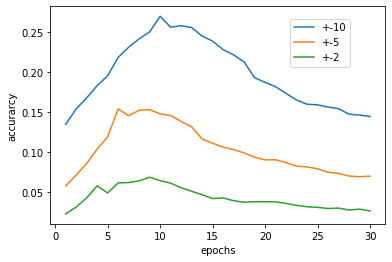

In [174]:
import matplotlib.pyplot as plt
A = np.array(epoch_losses)
B = np.array(epoch_test_acc10)
C = np.array(epoch_test_acc5)
D = np.array(epoch_test_acc2)
x = range(1,31)
plt.plot(x, B.flatten(), label = "+-10")
plt.plot(x, C.flatten(), label = "+-5")
plt.plot(x, D.flatten(), label = "+-2")
plt.xlabel('epochs')
plt.ylabel('accurarcy')
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.show()

[1469.39269177 1298.78161316 1940.48422121 ... 1175.34729332 2233.31221795
 2736.72133527]
